# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%load_ext autoreload
%autoreload 2

from unityagents import UnityEnvironment
import numpy as np
import random
from copy import deepcopy
import torch
from collections import deque
import matplotlib.pyplot as plt

from ddpg_agent import MADDPG_Agent
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # roll over states to next time step
        if np.any(dones):                                  # update the score (for each agent)
            states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
capacity = 1000000
batch_size = 600
episodes_before_train = 1000

agent = MADDPG_Agent(num_agents, state_size, action_size, batch_size, capacity, episodes_before_train)

In [6]:
#agent.printModelArch(agent.actors[0])

In [7]:
def maddpg(n_eps=10000, max_t=300, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores_list = []
    FloatTensor = torch.cuda.FloatTensor if agent.cuda_on else torch.FloatTensor
    for i_eps in range(1, n_eps+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                              # initialize the score (for each agent)
        if isinstance(states, np.ndarray):
            states = torch.from_numpy(states).float()
        states = states.type(FloatTensor)
        for t in range(max_t):
            actions = agent.act(states).data.cpu()
            env_info = env.step(actions.numpy())[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            if isinstance(next_states, np.ndarray):
                next_states = torch.from_numpy(next_states).float()
            next_states = next_states.type(FloatTensor)
            rewards = env_info.rewards                         # get reward (for each agent)
            rewards = torch.FloatTensor(rewards).type(FloatTensor)
            dones = env_info.local_done                        # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            scores += rewards.cpu().numpy()
        
            if np.any(dones):
                break
        agent.eps_done += 1
        scores_list.append(np.max(scores))
        print('Score (max over agents) from episode {}: {}'.format(i_eps, np.max(scores)))
    return scores_list

        #if i_eps % 20 ==0:
            #agent.save_checkpoint(i_eps,np.max(scores))
   
                
            
scores_list = maddpg()

Score (max over agents) from episode 1: 0.10000000149011612
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0
Score (max over agents) from episode 6: 0.0
Score (max over agents) from episode 7: 0.0
Score (max over agents) from episode 8: 0.20000000298023224
Score (max over agents) from episode 9: 0.0
Score (max over agents) from episode 10: 0.09000000171363354
Score (max over agents) from episode 11: 0.0
Score (max over agents) from episode 12: 0.0
Score (max over agents) from episode 13: 0.09000000171363354
Score (max over agents) from episode 14: 0.0
Score (max over agents) from episode 15: 0.10000000149011612
Score (max over agents) from episode 16: 0.09000000171363354
Score (max over agents) from episode 17: 0.0
Score (max over agents) from episode 18: 0.0
Score (max over agents) from episode 19: 0.0
Score (max over agents) from episode 20: 0.0
Score (max ov

Score (max over agents) from episode 174: 0.10000000149011612
Score (max over agents) from episode 175: 0.0
Score (max over agents) from episode 176: 0.10000000149011612
Score (max over agents) from episode 177: 0.0
Score (max over agents) from episode 178: 0.0
Score (max over agents) from episode 179: 0.0
Score (max over agents) from episode 180: 0.10000000149011612
Score (max over agents) from episode 181: 0.0
Score (max over agents) from episode 182: 0.0
Score (max over agents) from episode 183: 0.0
Score (max over agents) from episode 184: 0.0
Score (max over agents) from episode 185: 0.0
Score (max over agents) from episode 186: 0.0
Score (max over agents) from episode 187: 0.0
Score (max over agents) from episode 188: 0.0
Score (max over agents) from episode 189: 0.09000000171363354
Score (max over agents) from episode 190: 0.0
Score (max over agents) from episode 191: 0.0
Score (max over agents) from episode 192: 0.0
Score (max over agents) from episode 193: 0.0
Score (max over 

Score (max over agents) from episode 346: 0.0
Score (max over agents) from episode 347: 0.0
Score (max over agents) from episode 348: 0.10000000149011612
Score (max over agents) from episode 349: 0.0
Score (max over agents) from episode 350: 0.0
Score (max over agents) from episode 351: 0.0
Score (max over agents) from episode 352: 0.10000000149011612
Score (max over agents) from episode 353: 0.0
Score (max over agents) from episode 354: 0.0
Score (max over agents) from episode 355: 0.0
Score (max over agents) from episode 356: 0.0
Score (max over agents) from episode 357: 0.0
Score (max over agents) from episode 358: 0.0
Score (max over agents) from episode 359: 0.09000000171363354
Score (max over agents) from episode 360: 0.0
Score (max over agents) from episode 361: 0.0
Score (max over agents) from episode 362: 0.0
Score (max over agents) from episode 363: 0.0
Score (max over agents) from episode 364: 0.09000000171363354
Score (max over agents) from episode 365: 0.0
Score (max over 

Score (max over agents) from episode 519: 0.0
Score (max over agents) from episode 520: 0.0
Score (max over agents) from episode 521: 0.0
Score (max over agents) from episode 522: 0.0
Score (max over agents) from episode 523: 0.0
Score (max over agents) from episode 524: 0.0
Score (max over agents) from episode 525: 0.0
Score (max over agents) from episode 526: 0.0
Score (max over agents) from episode 527: 0.0
Score (max over agents) from episode 528: 0.0
Score (max over agents) from episode 529: 0.0
Score (max over agents) from episode 530: 0.0
Score (max over agents) from episode 531: 0.0
Score (max over agents) from episode 532: 0.0
Score (max over agents) from episode 533: 0.0
Score (max over agents) from episode 534: 0.0
Score (max over agents) from episode 535: 0.0
Score (max over agents) from episode 536: 0.0
Score (max over agents) from episode 537: 0.0
Score (max over agents) from episode 538: 0.0
Score (max over agents) from episode 539: 0.0
Score (max over agents) from episo

Score (max over agents) from episode 688: 0.0
Score (max over agents) from episode 689: 0.0
Score (max over agents) from episode 690: 0.10000000149011612
Score (max over agents) from episode 691: 0.0
Score (max over agents) from episode 692: 0.0
Score (max over agents) from episode 693: 0.0
Score (max over agents) from episode 694: 0.0
Score (max over agents) from episode 695: 0.10000000149011612
Score (max over agents) from episode 696: 0.0
Score (max over agents) from episode 697: 0.0
Score (max over agents) from episode 698: 0.0
Score (max over agents) from episode 699: 0.0
Score (max over agents) from episode 700: 0.0
Score (max over agents) from episode 701: 0.0
Score (max over agents) from episode 702: 0.0
Score (max over agents) from episode 703: 0.0
Score (max over agents) from episode 704: 0.0
Score (max over agents) from episode 705: 0.0
Score (max over agents) from episode 706: 0.0
Score (max over agents) from episode 707: 0.0
Score (max over agents) from episode 708: 0.0
Sc

Score (max over agents) from episode 859: 0.0
Score (max over agents) from episode 860: 0.0
Score (max over agents) from episode 861: 0.10000000149011612
Score (max over agents) from episode 862: 0.0
Score (max over agents) from episode 863: 0.10000000149011612
Score (max over agents) from episode 864: 0.0
Score (max over agents) from episode 865: 0.0
Score (max over agents) from episode 866: 0.0
Score (max over agents) from episode 867: 0.09000000171363354
Score (max over agents) from episode 868: 0.0
Score (max over agents) from episode 869: 0.0
Score (max over agents) from episode 870: 0.0
Score (max over agents) from episode 871: 0.0
Score (max over agents) from episode 872: 0.0
Score (max over agents) from episode 873: 0.0
Score (max over agents) from episode 874: 0.0
Score (max over agents) from episode 875: 0.0
Score (max over agents) from episode 876: 0.0
Score (max over agents) from episode 877: 0.10000000149011612
Score (max over agents) from episode 878: 0.0
Score (max over 

Score (max over agents) from episode 1016: 0.0
Score (max over agents) from episode 1017: 0.0
Score (max over agents) from episode 1018: 0.10000000149011612
Score (max over agents) from episode 1019: 0.0
Score (max over agents) from episode 1020: 0.0
Score (max over agents) from episode 1021: 0.0
Score (max over agents) from episode 1022: 0.0
Score (max over agents) from episode 1023: 0.0
Score (max over agents) from episode 1024: 0.0
Score (max over agents) from episode 1025: 0.0
Score (max over agents) from episode 1026: 0.0
Score (max over agents) from episode 1027: 0.0
Score (max over agents) from episode 1028: 0.0
Score (max over agents) from episode 1029: 0.0
Score (max over agents) from episode 1030: 0.10000000149011612
Score (max over agents) from episode 1031: 0.0
Score (max over agents) from episode 1032: 0.0
Score (max over agents) from episode 1033: 0.0
Score (max over agents) from episode 1034: 0.0
Score (max over agents) from episode 1035: 0.0
Score (max over agents) from

Score (max over agents) from episode 1188: 0.0
Score (max over agents) from episode 1189: 0.0
Score (max over agents) from episode 1190: 0.0
Score (max over agents) from episode 1191: 0.0
Score (max over agents) from episode 1192: 0.0
Score (max over agents) from episode 1193: 0.0
Score (max over agents) from episode 1194: 0.0
Score (max over agents) from episode 1195: 0.0
Score (max over agents) from episode 1196: 0.0
Score (max over agents) from episode 1197: 0.0
Score (max over agents) from episode 1198: 0.0
Score (max over agents) from episode 1199: 0.0
Score (max over agents) from episode 1200: 0.0
Score (max over agents) from episode 1201: 0.0
Score (max over agents) from episode 1202: 0.0
Score (max over agents) from episode 1203: 0.0
Score (max over agents) from episode 1204: 0.0
Score (max over agents) from episode 1205: 0.0
Score (max over agents) from episode 1206: 0.0
Score (max over agents) from episode 1207: 0.0
Score (max over agents) from episode 1208: 0.0
Score (max ov

Score (max over agents) from episode 1360: 0.0
Score (max over agents) from episode 1361: 0.0
Score (max over agents) from episode 1362: 0.0
Score (max over agents) from episode 1363: 0.0
Score (max over agents) from episode 1364: 0.0
Score (max over agents) from episode 1365: 0.0
Score (max over agents) from episode 1366: 0.0
Score (max over agents) from episode 1367: 0.0
Score (max over agents) from episode 1368: 0.0
Score (max over agents) from episode 1369: 0.0
Score (max over agents) from episode 1370: 0.0
Score (max over agents) from episode 1371: 0.0
Score (max over agents) from episode 1372: 0.0
Score (max over agents) from episode 1373: 0.0
Score (max over agents) from episode 1374: 0.0
Score (max over agents) from episode 1375: 0.0
Score (max over agents) from episode 1376: 0.0
Score (max over agents) from episode 1377: 0.0
Score (max over agents) from episode 1378: 0.0
Score (max over agents) from episode 1379: 0.0
Score (max over agents) from episode 1380: 0.0
Score (max ov

Score (max over agents) from episode 1533: 0.0
Score (max over agents) from episode 1534: 0.0
Score (max over agents) from episode 1535: 0.0
Score (max over agents) from episode 1536: 0.0
Score (max over agents) from episode 1537: 0.0
Score (max over agents) from episode 1538: 0.0
Score (max over agents) from episode 1539: 0.0
Score (max over agents) from episode 1540: 0.0
Score (max over agents) from episode 1541: 0.0
Score (max over agents) from episode 1542: 0.0
Score (max over agents) from episode 1543: 0.0
Score (max over agents) from episode 1544: 0.0
Score (max over agents) from episode 1545: 0.0
Score (max over agents) from episode 1546: 0.0
Score (max over agents) from episode 1547: 0.0
Score (max over agents) from episode 1548: 0.0
Score (max over agents) from episode 1549: 0.0
Score (max over agents) from episode 1550: 0.0
Score (max over agents) from episode 1551: 0.0
Score (max over agents) from episode 1552: 0.0
Score (max over agents) from episode 1553: 0.0
Score (max ov

Score (max over agents) from episode 1704: 0.0
Score (max over agents) from episode 1705: 0.0
Score (max over agents) from episode 1706: 0.0
Score (max over agents) from episode 1707: 0.0
Score (max over agents) from episode 1708: 0.0
Score (max over agents) from episode 1709: 0.0
Score (max over agents) from episode 1710: 0.0
Score (max over agents) from episode 1711: 0.0
Score (max over agents) from episode 1712: 0.0
Score (max over agents) from episode 1713: 0.0
Score (max over agents) from episode 1714: 0.0
Score (max over agents) from episode 1715: 0.0
Score (max over agents) from episode 1716: 0.0
Score (max over agents) from episode 1717: 0.0
Score (max over agents) from episode 1718: 0.0
Score (max over agents) from episode 1719: 0.0
Score (max over agents) from episode 1720: 0.0
Score (max over agents) from episode 1721: 0.0
Score (max over agents) from episode 1722: 0.0
Score (max over agents) from episode 1723: 0.0
Score (max over agents) from episode 1724: 0.0
Score (max ov

Score (max over agents) from episode 1877: 0.10000000149011612
Score (max over agents) from episode 1878: 0.0
Score (max over agents) from episode 1879: 0.0
Score (max over agents) from episode 1880: 0.0
Score (max over agents) from episode 1881: 0.0
Score (max over agents) from episode 1882: 0.0
Score (max over agents) from episode 1883: 0.0
Score (max over agents) from episode 1884: 0.0
Score (max over agents) from episode 1885: 0.0
Score (max over agents) from episode 1886: 0.10000000149011612
Score (max over agents) from episode 1887: 0.0
Score (max over agents) from episode 1888: 0.0
Score (max over agents) from episode 1889: 0.0
Score (max over agents) from episode 1890: 0.0
Score (max over agents) from episode 1891: 0.0
Score (max over agents) from episode 1892: 0.0
Score (max over agents) from episode 1893: 0.0
Score (max over agents) from episode 1894: 0.0
Score (max over agents) from episode 1895: 0.0
Score (max over agents) from episode 1896: 0.0
Score (max over agents) from

Score (max over agents) from episode 2049: 0.0
Score (max over agents) from episode 2050: 0.0
Score (max over agents) from episode 2051: 0.0
Score (max over agents) from episode 2052: 0.0
Score (max over agents) from episode 2053: 0.0
Score (max over agents) from episode 2054: 0.0
Score (max over agents) from episode 2055: 0.0
Score (max over agents) from episode 2056: 0.10000000149011612
Score (max over agents) from episode 2057: 0.0
Score (max over agents) from episode 2058: 0.0
Score (max over agents) from episode 2059: 0.0
Score (max over agents) from episode 2060: 0.0
Score (max over agents) from episode 2061: 0.10000000149011612
Score (max over agents) from episode 2062: 0.0
Score (max over agents) from episode 2063: 0.0
Score (max over agents) from episode 2064: 0.0
Score (max over agents) from episode 2065: 0.0
Score (max over agents) from episode 2066: 0.0
Score (max over agents) from episode 2067: 0.0
Score (max over agents) from episode 2068: 0.0
Score (max over agents) from

Score (max over agents) from episode 2223: 0.0
Score (max over agents) from episode 2224: 0.0
Score (max over agents) from episode 2225: 0.0
Score (max over agents) from episode 2226: 0.0
Score (max over agents) from episode 2227: 0.0
Score (max over agents) from episode 2228: 0.0
Score (max over agents) from episode 2229: 0.0
Score (max over agents) from episode 2230: 0.0
Score (max over agents) from episode 2231: 0.0
Score (max over agents) from episode 2232: 0.0
Score (max over agents) from episode 2233: 0.0
Score (max over agents) from episode 2234: 0.0
Score (max over agents) from episode 2235: 0.0
Score (max over agents) from episode 2236: 0.0
Score (max over agents) from episode 2237: 0.0
Score (max over agents) from episode 2238: 0.0
Score (max over agents) from episode 2239: 0.0
Score (max over agents) from episode 2240: 0.0
Score (max over agents) from episode 2241: 0.0
Score (max over agents) from episode 2242: 0.0
Score (max over agents) from episode 2243: 0.0
Score (max ov

Score (max over agents) from episode 2398: 0.0
Score (max over agents) from episode 2399: 0.0
Score (max over agents) from episode 2400: 0.0
Score (max over agents) from episode 2401: 0.0
Score (max over agents) from episode 2402: 0.0
Score (max over agents) from episode 2403: 0.0
Score (max over agents) from episode 2404: 0.0
Score (max over agents) from episode 2405: 0.0
Score (max over agents) from episode 2406: 0.0
Score (max over agents) from episode 2407: 0.0
Score (max over agents) from episode 2408: 0.0
Score (max over agents) from episode 2409: 0.0
Score (max over agents) from episode 2410: 0.0
Score (max over agents) from episode 2411: 0.0
Score (max over agents) from episode 2412: 0.0
Score (max over agents) from episode 2413: 0.0
Score (max over agents) from episode 2414: 0.0
Score (max over agents) from episode 2415: 0.0
Score (max over agents) from episode 2416: 0.0
Score (max over agents) from episode 2417: 0.0
Score (max over agents) from episode 2418: 0.0
Score (max ov

Score (max over agents) from episode 2573: 0.0
Score (max over agents) from episode 2574: 0.0
Score (max over agents) from episode 2575: 0.0
Score (max over agents) from episode 2576: 0.0
Score (max over agents) from episode 2577: 0.0
Score (max over agents) from episode 2578: 0.0
Score (max over agents) from episode 2579: 0.0
Score (max over agents) from episode 2580: 0.0
Score (max over agents) from episode 2581: 0.0
Score (max over agents) from episode 2582: 0.0
Score (max over agents) from episode 2583: 0.0
Score (max over agents) from episode 2584: 0.0
Score (max over agents) from episode 2585: 0.0
Score (max over agents) from episode 2586: 0.0
Score (max over agents) from episode 2587: 0.0
Score (max over agents) from episode 2588: 0.0
Score (max over agents) from episode 2589: 0.0
Score (max over agents) from episode 2590: 0.0
Score (max over agents) from episode 2591: 0.0
Score (max over agents) from episode 2592: 0.0
Score (max over agents) from episode 2593: 0.0
Score (max ov

Score (max over agents) from episode 2746: 0.0
Score (max over agents) from episode 2747: 0.0
Score (max over agents) from episode 2748: 0.0
Score (max over agents) from episode 2749: 0.0
Score (max over agents) from episode 2750: 0.0
Score (max over agents) from episode 2751: 0.0
Score (max over agents) from episode 2752: 0.0
Score (max over agents) from episode 2753: 0.0
Score (max over agents) from episode 2754: 0.0
Score (max over agents) from episode 2755: 0.0
Score (max over agents) from episode 2756: 0.0
Score (max over agents) from episode 2757: 0.0
Score (max over agents) from episode 2758: 0.0
Score (max over agents) from episode 2759: 0.0
Score (max over agents) from episode 2760: 0.0
Score (max over agents) from episode 2761: 0.0
Score (max over agents) from episode 2762: 0.0
Score (max over agents) from episode 2763: 0.0
Score (max over agents) from episode 2764: 0.0
Score (max over agents) from episode 2765: 0.0
Score (max over agents) from episode 2766: 0.0
Score (max ov

Score (max over agents) from episode 2919: 0.10000000149011612
Score (max over agents) from episode 2920: 0.0
Score (max over agents) from episode 2921: 0.0
Score (max over agents) from episode 2922: 0.0
Score (max over agents) from episode 2923: 0.0
Score (max over agents) from episode 2924: 0.0
Score (max over agents) from episode 2925: 0.0
Score (max over agents) from episode 2926: 0.0
Score (max over agents) from episode 2927: 0.0
Score (max over agents) from episode 2928: 0.0
Score (max over agents) from episode 2929: 0.0
Score (max over agents) from episode 2930: 0.0
Score (max over agents) from episode 2931: 0.0
Score (max over agents) from episode 2932: 0.0
Score (max over agents) from episode 2933: 0.0
Score (max over agents) from episode 2934: 0.0
Score (max over agents) from episode 2935: 0.0
Score (max over agents) from episode 2936: 0.0
Score (max over agents) from episode 2937: 0.0
Score (max over agents) from episode 2938: 0.0
Score (max over agents) from episode 2939: 0

Score (max over agents) from episode 3092: 0.0
Score (max over agents) from episode 3093: 0.0
Score (max over agents) from episode 3094: 0.0
Score (max over agents) from episode 3095: 0.0
Score (max over agents) from episode 3096: 0.0
Score (max over agents) from episode 3097: 0.0
Score (max over agents) from episode 3098: 0.0
Score (max over agents) from episode 3099: 0.0
Score (max over agents) from episode 3100: 0.0
Score (max over agents) from episode 3101: 0.0
Score (max over agents) from episode 3102: 0.0
Score (max over agents) from episode 3103: 0.0
Score (max over agents) from episode 3104: 0.0
Score (max over agents) from episode 3105: 0.0
Score (max over agents) from episode 3106: 0.0
Score (max over agents) from episode 3107: 0.0
Score (max over agents) from episode 3108: 0.0
Score (max over agents) from episode 3109: 0.0
Score (max over agents) from episode 3110: 0.0
Score (max over agents) from episode 3111: 0.0
Score (max over agents) from episode 3112: 0.0
Score (max ov

Score (max over agents) from episode 3267: 0.0
Score (max over agents) from episode 3268: 0.0
Score (max over agents) from episode 3269: 0.0
Score (max over agents) from episode 3270: 0.0
Score (max over agents) from episode 3271: 0.0
Score (max over agents) from episode 3272: 0.0
Score (max over agents) from episode 3273: 0.0
Score (max over agents) from episode 3274: 0.0
Score (max over agents) from episode 3275: 0.0
Score (max over agents) from episode 3276: 0.0
Score (max over agents) from episode 3277: 0.0
Score (max over agents) from episode 3278: 0.0
Score (max over agents) from episode 3279: 0.0
Score (max over agents) from episode 3280: 0.0
Score (max over agents) from episode 3281: 0.0
Score (max over agents) from episode 3282: 0.0
Score (max over agents) from episode 3283: 0.0
Score (max over agents) from episode 3284: 0.0
Score (max over agents) from episode 3285: 0.0
Score (max over agents) from episode 3286: 0.0
Score (max over agents) from episode 3287: 0.0
Score (max ov

Score (max over agents) from episode 3442: 0.0
Score (max over agents) from episode 3443: 0.0
Score (max over agents) from episode 3444: 0.0
Score (max over agents) from episode 3445: 0.0
Score (max over agents) from episode 3446: 0.0
Score (max over agents) from episode 3447: 0.0
Score (max over agents) from episode 3448: 0.0
Score (max over agents) from episode 3449: 0.0
Score (max over agents) from episode 3450: 0.0
Score (max over agents) from episode 3451: 0.0
Score (max over agents) from episode 3452: 0.0
Score (max over agents) from episode 3453: 0.10000000149011612
Score (max over agents) from episode 3454: 0.0
Score (max over agents) from episode 3455: 0.0
Score (max over agents) from episode 3456: 0.0
Score (max over agents) from episode 3457: 0.0
Score (max over agents) from episode 3458: 0.0
Score (max over agents) from episode 3459: 0.0
Score (max over agents) from episode 3460: 0.0
Score (max over agents) from episode 3461: 0.0
Score (max over agents) from episode 3462: 0

Score (max over agents) from episode 3615: 0.0
Score (max over agents) from episode 3616: 0.0
Score (max over agents) from episode 3617: 0.0
Score (max over agents) from episode 3618: 0.0
Score (max over agents) from episode 3619: 0.0
Score (max over agents) from episode 3620: 0.0
Score (max over agents) from episode 3621: 0.0
Score (max over agents) from episode 3622: 0.0
Score (max over agents) from episode 3623: 0.0
Score (max over agents) from episode 3624: 0.0
Score (max over agents) from episode 3625: 0.0
Score (max over agents) from episode 3626: 0.0
Score (max over agents) from episode 3627: 0.0
Score (max over agents) from episode 3628: 0.0
Score (max over agents) from episode 3629: 0.0
Score (max over agents) from episode 3630: 0.0
Score (max over agents) from episode 3631: 0.0
Score (max over agents) from episode 3632: 0.0
Score (max over agents) from episode 3633: 0.0
Score (max over agents) from episode 3634: 0.0
Score (max over agents) from episode 3635: 0.0
Score (max ov

Score (max over agents) from episode 3790: 0.0
Score (max over agents) from episode 3791: 0.0
Score (max over agents) from episode 3792: 0.0
Score (max over agents) from episode 3793: 0.0
Score (max over agents) from episode 3794: 0.0
Score (max over agents) from episode 3795: 0.0
Score (max over agents) from episode 3796: 0.0
Score (max over agents) from episode 3797: 0.0
Score (max over agents) from episode 3798: 0.0
Score (max over agents) from episode 3799: 0.0
Score (max over agents) from episode 3800: 0.0
Score (max over agents) from episode 3801: 0.0
Score (max over agents) from episode 3802: 0.0
Score (max over agents) from episode 3803: 0.0
Score (max over agents) from episode 3804: 0.0
Score (max over agents) from episode 3805: 0.0
Score (max over agents) from episode 3806: 0.0
Score (max over agents) from episode 3807: 0.0
Score (max over agents) from episode 3808: 0.0
Score (max over agents) from episode 3809: 0.0
Score (max over agents) from episode 3810: 0.0
Score (max ov

Score (max over agents) from episode 3963: 0.0
Score (max over agents) from episode 3964: 0.0
Score (max over agents) from episode 3965: 0.0
Score (max over agents) from episode 3966: 0.0
Score (max over agents) from episode 3967: 0.0
Score (max over agents) from episode 3968: 0.0
Score (max over agents) from episode 3969: 0.0
Score (max over agents) from episode 3970: 0.0
Score (max over agents) from episode 3971: 0.0
Score (max over agents) from episode 3972: 0.0
Score (max over agents) from episode 3973: 0.0
Score (max over agents) from episode 3974: 0.0
Score (max over agents) from episode 3975: 0.0
Score (max over agents) from episode 3976: 0.10000000149011612
Score (max over agents) from episode 3977: 0.0
Score (max over agents) from episode 3978: 0.0
Score (max over agents) from episode 3979: 0.0
Score (max over agents) from episode 3980: 0.0
Score (max over agents) from episode 3981: 0.0
Score (max over agents) from episode 3982: 0.10000000149011612
Score (max over agents) from

Score (max over agents) from episode 4136: 0.0
Score (max over agents) from episode 4137: 0.0
Score (max over agents) from episode 4138: 0.0
Score (max over agents) from episode 4139: 0.0
Score (max over agents) from episode 4140: 0.0
Score (max over agents) from episode 4141: 0.0
Score (max over agents) from episode 4142: 0.0
Score (max over agents) from episode 4143: 0.0
Score (max over agents) from episode 4144: 0.0
Score (max over agents) from episode 4145: 0.10000000149011612
Score (max over agents) from episode 4146: 0.0
Score (max over agents) from episode 4147: 0.0
Score (max over agents) from episode 4148: 0.0
Score (max over agents) from episode 4149: 0.0
Score (max over agents) from episode 4150: 0.0
Score (max over agents) from episode 4151: 0.0
Score (max over agents) from episode 4152: 0.0
Score (max over agents) from episode 4153: 0.0
Score (max over agents) from episode 4154: 0.0
Score (max over agents) from episode 4155: 0.0
Score (max over agents) from episode 4156: 0

Score (max over agents) from episode 4310: 0.0
Score (max over agents) from episode 4311: 0.0
Score (max over agents) from episode 4312: 0.0
Score (max over agents) from episode 4313: 0.0
Score (max over agents) from episode 4314: 0.0
Score (max over agents) from episode 4315: 0.0
Score (max over agents) from episode 4316: 0.0
Score (max over agents) from episode 4317: 0.0
Score (max over agents) from episode 4318: 0.0
Score (max over agents) from episode 4319: 0.0
Score (max over agents) from episode 4320: 0.0
Score (max over agents) from episode 4321: 0.0
Score (max over agents) from episode 4322: 0.0
Score (max over agents) from episode 4323: 0.0
Score (max over agents) from episode 4324: 0.0
Score (max over agents) from episode 4325: 0.0
Score (max over agents) from episode 4326: 0.0
Score (max over agents) from episode 4327: 0.0
Score (max over agents) from episode 4328: 0.0
Score (max over agents) from episode 4329: 0.0
Score (max over agents) from episode 4330: 0.0
Score (max ov

Score (max over agents) from episode 4484: 0.0
Score (max over agents) from episode 4485: 0.0
Score (max over agents) from episode 4486: 0.0
Score (max over agents) from episode 4487: 0.0
Score (max over agents) from episode 4488: 0.0
Score (max over agents) from episode 4489: 0.0
Score (max over agents) from episode 4490: 0.0
Score (max over agents) from episode 4491: 0.0
Score (max over agents) from episode 4492: 0.0
Score (max over agents) from episode 4493: 0.0
Score (max over agents) from episode 4494: 0.0
Score (max over agents) from episode 4495: 0.0
Score (max over agents) from episode 4496: 0.0
Score (max over agents) from episode 4497: 0.0
Score (max over agents) from episode 4498: 0.0
Score (max over agents) from episode 4499: 0.0
Score (max over agents) from episode 4500: 0.0
Score (max over agents) from episode 4501: 0.0
Score (max over agents) from episode 4502: 0.0
Score (max over agents) from episode 4503: 0.0
Score (max over agents) from episode 4504: 0.0
Score (max ov

Score (max over agents) from episode 4659: 0.0
Score (max over agents) from episode 4660: 0.0
Score (max over agents) from episode 4661: 0.0
Score (max over agents) from episode 4662: 0.0
Score (max over agents) from episode 4663: 0.0
Score (max over agents) from episode 4664: 0.0
Score (max over agents) from episode 4665: 0.0
Score (max over agents) from episode 4666: 0.0
Score (max over agents) from episode 4667: 0.0
Score (max over agents) from episode 4668: 0.0
Score (max over agents) from episode 4669: 0.0
Score (max over agents) from episode 4670: 0.0
Score (max over agents) from episode 4671: 0.0
Score (max over agents) from episode 4672: 0.0
Score (max over agents) from episode 4673: 0.0
Score (max over agents) from episode 4674: 0.0
Score (max over agents) from episode 4675: 0.0
Score (max over agents) from episode 4676: 0.0
Score (max over agents) from episode 4677: 0.0
Score (max over agents) from episode 4678: 0.0
Score (max over agents) from episode 4679: 0.0
Score (max ov

Score (max over agents) from episode 4833: 0.0
Score (max over agents) from episode 4834: 0.0
Score (max over agents) from episode 4835: 0.0
Score (max over agents) from episode 4836: 0.0
Score (max over agents) from episode 4837: 0.0
Score (max over agents) from episode 4838: 0.10000000149011612
Score (max over agents) from episode 4839: 0.0
Score (max over agents) from episode 4840: 0.0
Score (max over agents) from episode 4841: 0.0
Score (max over agents) from episode 4842: 0.0
Score (max over agents) from episode 4843: 0.0
Score (max over agents) from episode 4844: 0.0
Score (max over agents) from episode 4845: 0.0
Score (max over agents) from episode 4846: 0.0
Score (max over agents) from episode 4847: 0.0
Score (max over agents) from episode 4848: 0.0
Score (max over agents) from episode 4849: 0.0
Score (max over agents) from episode 4850: 0.0
Score (max over agents) from episode 4851: 0.0
Score (max over agents) from episode 4852: 0.0
Score (max over agents) from episode 4853: 0

Score (max over agents) from episode 5006: 0.0
Score (max over agents) from episode 5007: 0.0
Score (max over agents) from episode 5008: 0.0
Score (max over agents) from episode 5009: 0.0
Score (max over agents) from episode 5010: 0.0
Score (max over agents) from episode 5011: 0.0
Score (max over agents) from episode 5012: 0.0
Score (max over agents) from episode 5013: 0.0
Score (max over agents) from episode 5014: 0.0
Score (max over agents) from episode 5015: 0.0
Score (max over agents) from episode 5016: 0.0
Score (max over agents) from episode 5017: 0.0
Score (max over agents) from episode 5018: 0.0
Score (max over agents) from episode 5019: 0.0
Score (max over agents) from episode 5020: 0.0
Score (max over agents) from episode 5021: 0.0
Score (max over agents) from episode 5022: 0.0
Score (max over agents) from episode 5023: 0.0
Score (max over agents) from episode 5024: 0.0
Score (max over agents) from episode 5025: 0.0
Score (max over agents) from episode 5026: 0.0
Score (max ov

Score (max over agents) from episode 5181: 0.0
Score (max over agents) from episode 5182: 0.0
Score (max over agents) from episode 5183: 0.0
Score (max over agents) from episode 5184: 0.0
Score (max over agents) from episode 5185: 0.0
Score (max over agents) from episode 5186: 0.0
Score (max over agents) from episode 5187: 0.0
Score (max over agents) from episode 5188: 0.0
Score (max over agents) from episode 5189: 0.0
Score (max over agents) from episode 5190: 0.0
Score (max over agents) from episode 5191: 0.0
Score (max over agents) from episode 5192: 0.0
Score (max over agents) from episode 5193: 0.0
Score (max over agents) from episode 5194: 0.0
Score (max over agents) from episode 5195: 0.10000000149011612
Score (max over agents) from episode 5196: 0.0
Score (max over agents) from episode 5197: 0.0
Score (max over agents) from episode 5198: 0.0
Score (max over agents) from episode 5199: 0.0
Score (max over agents) from episode 5200: 0.0
Score (max over agents) from episode 5201: 0

Score (max over agents) from episode 5355: 0.0
Score (max over agents) from episode 5356: 0.0
Score (max over agents) from episode 5357: 0.0
Score (max over agents) from episode 5358: 0.0
Score (max over agents) from episode 5359: 0.0
Score (max over agents) from episode 5360: 0.0
Score (max over agents) from episode 5361: 0.0
Score (max over agents) from episode 5362: 0.0
Score (max over agents) from episode 5363: 0.0
Score (max over agents) from episode 5364: 0.0
Score (max over agents) from episode 5365: 0.0
Score (max over agents) from episode 5366: 0.0
Score (max over agents) from episode 5367: 0.0
Score (max over agents) from episode 5368: 0.0
Score (max over agents) from episode 5369: 0.0
Score (max over agents) from episode 5370: 0.0
Score (max over agents) from episode 5371: 0.0
Score (max over agents) from episode 5372: 0.0
Score (max over agents) from episode 5373: 0.0
Score (max over agents) from episode 5374: 0.0
Score (max over agents) from episode 5375: 0.0
Score (max ov

Score (max over agents) from episode 5530: 0.0
Score (max over agents) from episode 5531: 0.0
Score (max over agents) from episode 5532: 0.0
Score (max over agents) from episode 5533: 0.0
Score (max over agents) from episode 5534: 0.0
Score (max over agents) from episode 5535: 0.0
Score (max over agents) from episode 5536: 0.0
Score (max over agents) from episode 5537: 0.0
Score (max over agents) from episode 5538: 0.0
Score (max over agents) from episode 5539: 0.0
Score (max over agents) from episode 5540: 0.0
Score (max over agents) from episode 5541: 0.0
Score (max over agents) from episode 5542: 0.0
Score (max over agents) from episode 5543: 0.0
Score (max over agents) from episode 5544: 0.0
Score (max over agents) from episode 5545: 0.0
Score (max over agents) from episode 5546: 0.0
Score (max over agents) from episode 5547: 0.0
Score (max over agents) from episode 5548: 0.0
Score (max over agents) from episode 5549: 0.0
Score (max over agents) from episode 5550: 0.0
Score (max ov

Score (max over agents) from episode 5705: 0.0
Score (max over agents) from episode 5706: 0.0
Score (max over agents) from episode 5707: 0.0
Score (max over agents) from episode 5708: 0.0
Score (max over agents) from episode 5709: 0.0
Score (max over agents) from episode 5710: 0.0
Score (max over agents) from episode 5711: 0.0
Score (max over agents) from episode 5712: 0.0
Score (max over agents) from episode 5713: 0.0
Score (max over agents) from episode 5714: 0.0
Score (max over agents) from episode 5715: 0.0
Score (max over agents) from episode 5716: 0.0
Score (max over agents) from episode 5717: 0.0
Score (max over agents) from episode 5718: 0.0
Score (max over agents) from episode 5719: 0.0
Score (max over agents) from episode 5720: 0.0
Score (max over agents) from episode 5721: 0.0
Score (max over agents) from episode 5722: 0.0
Score (max over agents) from episode 5723: 0.0
Score (max over agents) from episode 5724: 0.0
Score (max over agents) from episode 5725: 0.0
Score (max ov

Score (max over agents) from episode 5880: 0.0
Score (max over agents) from episode 5881: 0.0
Score (max over agents) from episode 5882: 0.0
Score (max over agents) from episode 5883: 0.0
Score (max over agents) from episode 5884: 0.0
Score (max over agents) from episode 5885: 0.0
Score (max over agents) from episode 5886: 0.0
Score (max over agents) from episode 5887: 0.0
Score (max over agents) from episode 5888: 0.0
Score (max over agents) from episode 5889: 0.0
Score (max over agents) from episode 5890: 0.0
Score (max over agents) from episode 5891: 0.0
Score (max over agents) from episode 5892: 0.0
Score (max over agents) from episode 5893: 0.0
Score (max over agents) from episode 5894: 0.0
Score (max over agents) from episode 5895: 0.0
Score (max over agents) from episode 5896: 0.0
Score (max over agents) from episode 5897: 0.0
Score (max over agents) from episode 5898: 0.0
Score (max over agents) from episode 5899: 0.0
Score (max over agents) from episode 5900: 0.0
Score (max ov

Score (max over agents) from episode 6055: 0.0
Score (max over agents) from episode 6056: 0.0
Score (max over agents) from episode 6057: 0.0
Score (max over agents) from episode 6058: 0.0
Score (max over agents) from episode 6059: 0.0
Score (max over agents) from episode 6060: 0.0
Score (max over agents) from episode 6061: 0.0
Score (max over agents) from episode 6062: 0.0
Score (max over agents) from episode 6063: 0.0
Score (max over agents) from episode 6064: 0.0
Score (max over agents) from episode 6065: 0.0
Score (max over agents) from episode 6066: 0.0
Score (max over agents) from episode 6067: 0.0
Score (max over agents) from episode 6068: 0.0
Score (max over agents) from episode 6069: 0.0
Score (max over agents) from episode 6070: 0.0
Score (max over agents) from episode 6071: 0.0
Score (max over agents) from episode 6072: 0.0
Score (max over agents) from episode 6073: 0.0
Score (max over agents) from episode 6074: 0.0
Score (max over agents) from episode 6075: 0.0
Score (max ov

Score (max over agents) from episode 6230: 0.0
Score (max over agents) from episode 6231: 0.0
Score (max over agents) from episode 6232: 0.0
Score (max over agents) from episode 6233: 0.0
Score (max over agents) from episode 6234: 0.0
Score (max over agents) from episode 6235: 0.0
Score (max over agents) from episode 6236: 0.0
Score (max over agents) from episode 6237: 0.0
Score (max over agents) from episode 6238: 0.0
Score (max over agents) from episode 6239: 0.0
Score (max over agents) from episode 6240: 0.0
Score (max over agents) from episode 6241: 0.0
Score (max over agents) from episode 6242: 0.0
Score (max over agents) from episode 6243: 0.0
Score (max over agents) from episode 6244: 0.0
Score (max over agents) from episode 6245: 0.0
Score (max over agents) from episode 6246: 0.0
Score (max over agents) from episode 6247: 0.0
Score (max over agents) from episode 6248: 0.0
Score (max over agents) from episode 6249: 0.0
Score (max over agents) from episode 6250: 0.0
Score (max ov

Score (max over agents) from episode 6405: 0.0
Score (max over agents) from episode 6406: 0.0
Score (max over agents) from episode 6407: 0.0
Score (max over agents) from episode 6408: 0.0
Score (max over agents) from episode 6409: 0.0
Score (max over agents) from episode 6410: 0.0
Score (max over agents) from episode 6411: 0.0
Score (max over agents) from episode 6412: 0.0
Score (max over agents) from episode 6413: 0.0
Score (max over agents) from episode 6414: 0.0
Score (max over agents) from episode 6415: 0.0
Score (max over agents) from episode 6416: 0.0
Score (max over agents) from episode 6417: 0.0
Score (max over agents) from episode 6418: 0.0
Score (max over agents) from episode 6419: 0.0
Score (max over agents) from episode 6420: 0.0
Score (max over agents) from episode 6421: 0.0
Score (max over agents) from episode 6422: 0.0
Score (max over agents) from episode 6423: 0.0
Score (max over agents) from episode 6424: 0.0
Score (max over agents) from episode 6425: 0.0
Score (max ov

Score (max over agents) from episode 6580: 0.0
Score (max over agents) from episode 6581: 0.0
Score (max over agents) from episode 6582: 0.0
Score (max over agents) from episode 6583: 0.0
Score (max over agents) from episode 6584: 0.0
Score (max over agents) from episode 6585: 0.0
Score (max over agents) from episode 6586: 0.0
Score (max over agents) from episode 6587: 0.0
Score (max over agents) from episode 6588: 0.0
Score (max over agents) from episode 6589: 0.0
Score (max over agents) from episode 6590: 0.0
Score (max over agents) from episode 6591: 0.0
Score (max over agents) from episode 6592: 0.0
Score (max over agents) from episode 6593: 0.0
Score (max over agents) from episode 6594: 0.0
Score (max over agents) from episode 6595: 0.0
Score (max over agents) from episode 6596: 0.0
Score (max over agents) from episode 6597: 0.0
Score (max over agents) from episode 6598: 0.0
Score (max over agents) from episode 6599: 0.0
Score (max over agents) from episode 6600: 0.0
Score (max ov

Score (max over agents) from episode 6755: 0.0
Score (max over agents) from episode 6756: 0.0
Score (max over agents) from episode 6757: 0.0
Score (max over agents) from episode 6758: 0.0
Score (max over agents) from episode 6759: 0.0
Score (max over agents) from episode 6760: 0.0
Score (max over agents) from episode 6761: 0.0
Score (max over agents) from episode 6762: 0.0
Score (max over agents) from episode 6763: 0.0
Score (max over agents) from episode 6764: 0.0
Score (max over agents) from episode 6765: 0.0
Score (max over agents) from episode 6766: 0.0
Score (max over agents) from episode 6767: 0.0
Score (max over agents) from episode 6768: 0.0
Score (max over agents) from episode 6769: 0.0
Score (max over agents) from episode 6770: 0.0
Score (max over agents) from episode 6771: 0.0
Score (max over agents) from episode 6772: 0.0
Score (max over agents) from episode 6773: 0.0
Score (max over agents) from episode 6774: 0.0
Score (max over agents) from episode 6775: 0.0
Score (max ov

Score (max over agents) from episode 6930: 0.0
Score (max over agents) from episode 6931: 0.0
Score (max over agents) from episode 6932: 0.0
Score (max over agents) from episode 6933: 0.0
Score (max over agents) from episode 6934: 0.0
Score (max over agents) from episode 6935: 0.0
Score (max over agents) from episode 6936: 0.0
Score (max over agents) from episode 6937: 0.0
Score (max over agents) from episode 6938: 0.0
Score (max over agents) from episode 6939: 0.0
Score (max over agents) from episode 6940: 0.0
Score (max over agents) from episode 6941: 0.0
Score (max over agents) from episode 6942: 0.0
Score (max over agents) from episode 6943: 0.0
Score (max over agents) from episode 6944: 0.0
Score (max over agents) from episode 6945: 0.0
Score (max over agents) from episode 6946: 0.0
Score (max over agents) from episode 6947: 0.0
Score (max over agents) from episode 6948: 0.0
Score (max over agents) from episode 6949: 0.0
Score (max over agents) from episode 6950: 0.0
Score (max ov

Score (max over agents) from episode 7104: 0.0
Score (max over agents) from episode 7105: 0.0
Score (max over agents) from episode 7106: 0.0
Score (max over agents) from episode 7107: 0.0
Score (max over agents) from episode 7108: 0.0
Score (max over agents) from episode 7109: 0.0
Score (max over agents) from episode 7110: 0.0
Score (max over agents) from episode 7111: 0.0
Score (max over agents) from episode 7112: 0.0
Score (max over agents) from episode 7113: 0.0
Score (max over agents) from episode 7114: 0.0
Score (max over agents) from episode 7115: 0.0
Score (max over agents) from episode 7116: 0.0
Score (max over agents) from episode 7117: 0.0
Score (max over agents) from episode 7118: 0.0
Score (max over agents) from episode 7119: 0.0
Score (max over agents) from episode 7120: 0.0
Score (max over agents) from episode 7121: 0.0
Score (max over agents) from episode 7122: 0.0
Score (max over agents) from episode 7123: 0.0
Score (max over agents) from episode 7124: 0.0
Score (max ov

Score (max over agents) from episode 7279: 0.0
Score (max over agents) from episode 7280: 0.0
Score (max over agents) from episode 7281: 0.0
Score (max over agents) from episode 7282: 0.0
Score (max over agents) from episode 7283: 0.0
Score (max over agents) from episode 7284: 0.0
Score (max over agents) from episode 7285: 0.0
Score (max over agents) from episode 7286: 0.0
Score (max over agents) from episode 7287: 0.0
Score (max over agents) from episode 7288: 0.0
Score (max over agents) from episode 7289: 0.0
Score (max over agents) from episode 7290: 0.0
Score (max over agents) from episode 7291: 0.0
Score (max over agents) from episode 7292: 0.0
Score (max over agents) from episode 7293: 0.0
Score (max over agents) from episode 7294: 0.0
Score (max over agents) from episode 7295: 0.0
Score (max over agents) from episode 7296: 0.0
Score (max over agents) from episode 7297: 0.0
Score (max over agents) from episode 7298: 0.0
Score (max over agents) from episode 7299: 0.0
Score (max ov

Score (max over agents) from episode 7454: 0.0
Score (max over agents) from episode 7455: 0.0
Score (max over agents) from episode 7456: 0.0
Score (max over agents) from episode 7457: 0.0
Score (max over agents) from episode 7458: 0.0
Score (max over agents) from episode 7459: 0.0
Score (max over agents) from episode 7460: 0.0
Score (max over agents) from episode 7461: 0.0
Score (max over agents) from episode 7462: 0.0
Score (max over agents) from episode 7463: 0.0
Score (max over agents) from episode 7464: 0.0
Score (max over agents) from episode 7465: 0.0
Score (max over agents) from episode 7466: 0.0
Score (max over agents) from episode 7467: 0.0
Score (max over agents) from episode 7468: 0.0
Score (max over agents) from episode 7469: 0.0
Score (max over agents) from episode 7470: 0.0
Score (max over agents) from episode 7471: 0.0
Score (max over agents) from episode 7472: 0.0
Score (max over agents) from episode 7473: 0.0
Score (max over agents) from episode 7474: 0.0
Score (max ov

Score (max over agents) from episode 7629: 0.0
Score (max over agents) from episode 7630: 0.0
Score (max over agents) from episode 7631: 0.0
Score (max over agents) from episode 7632: 0.0
Score (max over agents) from episode 7633: 0.0
Score (max over agents) from episode 7634: 0.0
Score (max over agents) from episode 7635: 0.0
Score (max over agents) from episode 7636: 0.0
Score (max over agents) from episode 7637: 0.0
Score (max over agents) from episode 7638: 0.0
Score (max over agents) from episode 7639: 0.0
Score (max over agents) from episode 7640: 0.0
Score (max over agents) from episode 7641: 0.0
Score (max over agents) from episode 7642: 0.0
Score (max over agents) from episode 7643: 0.0
Score (max over agents) from episode 7644: 0.0
Score (max over agents) from episode 7645: 0.0
Score (max over agents) from episode 7646: 0.0
Score (max over agents) from episode 7647: 0.0
Score (max over agents) from episode 7648: 0.0
Score (max over agents) from episode 7649: 0.0
Score (max ov

Score (max over agents) from episode 7804: 0.0
Score (max over agents) from episode 7805: 0.0
Score (max over agents) from episode 7806: 0.0
Score (max over agents) from episode 7807: 0.0
Score (max over agents) from episode 7808: 0.0
Score (max over agents) from episode 7809: 0.0
Score (max over agents) from episode 7810: 0.0
Score (max over agents) from episode 7811: 0.0
Score (max over agents) from episode 7812: 0.0
Score (max over agents) from episode 7813: 0.0
Score (max over agents) from episode 7814: 0.0
Score (max over agents) from episode 7815: 0.0
Score (max over agents) from episode 7816: 0.0
Score (max over agents) from episode 7817: 0.0
Score (max over agents) from episode 7818: 0.0
Score (max over agents) from episode 7819: 0.0
Score (max over agents) from episode 7820: 0.0
Score (max over agents) from episode 7821: 0.0
Score (max over agents) from episode 7822: 0.0
Score (max over agents) from episode 7823: 0.0
Score (max over agents) from episode 7824: 0.0
Score (max ov

Score (max over agents) from episode 7979: 0.0
Score (max over agents) from episode 7980: 0.0
Score (max over agents) from episode 7981: 0.0
Score (max over agents) from episode 7982: 0.0
Score (max over agents) from episode 7983: 0.0
Score (max over agents) from episode 7984: 0.0
Score (max over agents) from episode 7985: 0.0
Score (max over agents) from episode 7986: 0.0
Score (max over agents) from episode 7987: 0.0
Score (max over agents) from episode 7988: 0.0
Score (max over agents) from episode 7989: 0.0
Score (max over agents) from episode 7990: 0.0
Score (max over agents) from episode 7991: 0.0
Score (max over agents) from episode 7992: 0.0
Score (max over agents) from episode 7993: 0.0
Score (max over agents) from episode 7994: 0.0
Score (max over agents) from episode 7995: 0.0
Score (max over agents) from episode 7996: 0.0
Score (max over agents) from episode 7997: 0.0
Score (max over agents) from episode 7998: 0.0
Score (max over agents) from episode 7999: 0.0
Score (max ov

Score (max over agents) from episode 8154: 0.0
Score (max over agents) from episode 8155: 0.0
Score (max over agents) from episode 8156: 0.0
Score (max over agents) from episode 8157: 0.0
Score (max over agents) from episode 8158: 0.0
Score (max over agents) from episode 8159: 0.0
Score (max over agents) from episode 8160: 0.0
Score (max over agents) from episode 8161: 0.0
Score (max over agents) from episode 8162: 0.0
Score (max over agents) from episode 8163: 0.0
Score (max over agents) from episode 8164: 0.0
Score (max over agents) from episode 8165: 0.0
Score (max over agents) from episode 8166: 0.0
Score (max over agents) from episode 8167: 0.0
Score (max over agents) from episode 8168: 0.0
Score (max over agents) from episode 8169: 0.0
Score (max over agents) from episode 8170: 0.0
Score (max over agents) from episode 8171: 0.0
Score (max over agents) from episode 8172: 0.0
Score (max over agents) from episode 8173: 0.0
Score (max over agents) from episode 8174: 0.0
Score (max ov

Score (max over agents) from episode 8328: 0.0
Score (max over agents) from episode 8329: 0.0
Score (max over agents) from episode 8330: 0.0
Score (max over agents) from episode 8331: 0.0
Score (max over agents) from episode 8332: 0.0
Score (max over agents) from episode 8333: 0.0
Score (max over agents) from episode 8334: 0.0
Score (max over agents) from episode 8335: 0.0
Score (max over agents) from episode 8336: 0.0
Score (max over agents) from episode 8337: 0.0
Score (max over agents) from episode 8338: 0.0
Score (max over agents) from episode 8339: 0.0
Score (max over agents) from episode 8340: 0.0
Score (max over agents) from episode 8341: 0.0
Score (max over agents) from episode 8342: 0.0
Score (max over agents) from episode 8343: 0.0
Score (max over agents) from episode 8344: 0.0
Score (max over agents) from episode 8345: 0.0
Score (max over agents) from episode 8346: 0.0
Score (max over agents) from episode 8347: 0.0
Score (max over agents) from episode 8348: 0.0
Score (max ov

Score (max over agents) from episode 8503: 0.0
Score (max over agents) from episode 8504: 0.0
Score (max over agents) from episode 8505: 0.0
Score (max over agents) from episode 8506: 0.0
Score (max over agents) from episode 8507: 0.0
Score (max over agents) from episode 8508: 0.0
Score (max over agents) from episode 8509: 0.0
Score (max over agents) from episode 8510: 0.0
Score (max over agents) from episode 8511: 0.0
Score (max over agents) from episode 8512: 0.0
Score (max over agents) from episode 8513: 0.0
Score (max over agents) from episode 8514: 0.0
Score (max over agents) from episode 8515: 0.0
Score (max over agents) from episode 8516: 0.0
Score (max over agents) from episode 8517: 0.0
Score (max over agents) from episode 8518: 0.0
Score (max over agents) from episode 8519: 0.0
Score (max over agents) from episode 8520: 0.0
Score (max over agents) from episode 8521: 0.0
Score (max over agents) from episode 8522: 0.0
Score (max over agents) from episode 8523: 0.0
Score (max ov

Score (max over agents) from episode 8678: 0.0
Score (max over agents) from episode 8679: 0.0
Score (max over agents) from episode 8680: 0.0
Score (max over agents) from episode 8681: 0.0
Score (max over agents) from episode 8682: 0.0
Score (max over agents) from episode 8683: 0.0
Score (max over agents) from episode 8684: 0.0
Score (max over agents) from episode 8685: 0.0
Score (max over agents) from episode 8686: 0.0
Score (max over agents) from episode 8687: 0.0
Score (max over agents) from episode 8688: 0.0
Score (max over agents) from episode 8689: 0.0
Score (max over agents) from episode 8690: 0.0
Score (max over agents) from episode 8691: 0.0
Score (max over agents) from episode 8692: 0.0
Score (max over agents) from episode 8693: 0.0
Score (max over agents) from episode 8694: 0.0
Score (max over agents) from episode 8695: 0.0
Score (max over agents) from episode 8696: 0.0
Score (max over agents) from episode 8697: 0.0
Score (max over agents) from episode 8698: 0.0
Score (max ov

Score (max over agents) from episode 8853: 0.0
Score (max over agents) from episode 8854: 0.0
Score (max over agents) from episode 8855: 0.0
Score (max over agents) from episode 8856: 0.0
Score (max over agents) from episode 8857: 0.0
Score (max over agents) from episode 8858: 0.0
Score (max over agents) from episode 8859: 0.0
Score (max over agents) from episode 8860: 0.0
Score (max over agents) from episode 8861: 0.0
Score (max over agents) from episode 8862: 0.0
Score (max over agents) from episode 8863: 0.0
Score (max over agents) from episode 8864: 0.0
Score (max over agents) from episode 8865: 0.0
Score (max over agents) from episode 8866: 0.0
Score (max over agents) from episode 8867: 0.0
Score (max over agents) from episode 8868: 0.0
Score (max over agents) from episode 8869: 0.0
Score (max over agents) from episode 8870: 0.0
Score (max over agents) from episode 8871: 0.0
Score (max over agents) from episode 8872: 0.0
Score (max over agents) from episode 8873: 0.0
Score (max ov

Score (max over agents) from episode 9028: 0.0
Score (max over agents) from episode 9029: 0.0
Score (max over agents) from episode 9030: 0.0
Score (max over agents) from episode 9031: 0.0
Score (max over agents) from episode 9032: 0.0
Score (max over agents) from episode 9033: 0.0
Score (max over agents) from episode 9034: 0.0
Score (max over agents) from episode 9035: 0.0
Score (max over agents) from episode 9036: 0.0
Score (max over agents) from episode 9037: 0.0
Score (max over agents) from episode 9038: 0.0
Score (max over agents) from episode 9039: 0.0
Score (max over agents) from episode 9040: 0.0
Score (max over agents) from episode 9041: 0.0
Score (max over agents) from episode 9042: 0.0
Score (max over agents) from episode 9043: 0.0
Score (max over agents) from episode 9044: 0.0
Score (max over agents) from episode 9045: 0.0
Score (max over agents) from episode 9046: 0.0
Score (max over agents) from episode 9047: 0.0
Score (max over agents) from episode 9048: 0.0
Score (max ov

Score (max over agents) from episode 9203: 0.0
Score (max over agents) from episode 9204: 0.0
Score (max over agents) from episode 9205: 0.0
Score (max over agents) from episode 9206: 0.0
Score (max over agents) from episode 9207: 0.0
Score (max over agents) from episode 9208: 0.0
Score (max over agents) from episode 9209: 0.0
Score (max over agents) from episode 9210: 0.0
Score (max over agents) from episode 9211: 0.0
Score (max over agents) from episode 9212: 0.0
Score (max over agents) from episode 9213: 0.0
Score (max over agents) from episode 9214: 0.0
Score (max over agents) from episode 9215: 0.0
Score (max over agents) from episode 9216: 0.0
Score (max over agents) from episode 9217: 0.0
Score (max over agents) from episode 9218: 0.0
Score (max over agents) from episode 9219: 0.0
Score (max over agents) from episode 9220: 0.0
Score (max over agents) from episode 9221: 0.0
Score (max over agents) from episode 9222: 0.0
Score (max over agents) from episode 9223: 0.0
Score (max ov

Score (max over agents) from episode 9378: 0.0
Score (max over agents) from episode 9379: 0.0
Score (max over agents) from episode 9380: 0.0
Score (max over agents) from episode 9381: 0.0
Score (max over agents) from episode 9382: 0.0
Score (max over agents) from episode 9383: 0.0
Score (max over agents) from episode 9384: 0.0
Score (max over agents) from episode 9385: 0.0
Score (max over agents) from episode 9386: 0.0
Score (max over agents) from episode 9387: 0.0
Score (max over agents) from episode 9388: 0.0
Score (max over agents) from episode 9389: 0.0
Score (max over agents) from episode 9390: 0.0
Score (max over agents) from episode 9391: 0.0
Score (max over agents) from episode 9392: 0.0
Score (max over agents) from episode 9393: 0.0
Score (max over agents) from episode 9394: 0.0
Score (max over agents) from episode 9395: 0.0
Score (max over agents) from episode 9396: 0.0
Score (max over agents) from episode 9397: 0.0
Score (max over agents) from episode 9398: 0.0
Score (max ov

Score (max over agents) from episode 9553: 0.0
Score (max over agents) from episode 9554: 0.0
Score (max over agents) from episode 9555: 0.0
Score (max over agents) from episode 9556: 0.0
Score (max over agents) from episode 9557: 0.0
Score (max over agents) from episode 9558: 0.0
Score (max over agents) from episode 9559: 0.0
Score (max over agents) from episode 9560: 0.0
Score (max over agents) from episode 9561: 0.0
Score (max over agents) from episode 9562: 0.0
Score (max over agents) from episode 9563: 0.0
Score (max over agents) from episode 9564: 0.0
Score (max over agents) from episode 9565: 0.0
Score (max over agents) from episode 9566: 0.0
Score (max over agents) from episode 9567: 0.0
Score (max over agents) from episode 9568: 0.0
Score (max over agents) from episode 9569: 0.0
Score (max over agents) from episode 9570: 0.0
Score (max over agents) from episode 9571: 0.0
Score (max over agents) from episode 9572: 0.0
Score (max over agents) from episode 9573: 0.0
Score (max ov

Score (max over agents) from episode 9728: 0.0
Score (max over agents) from episode 9729: 0.0
Score (max over agents) from episode 9730: 0.0
Score (max over agents) from episode 9731: 0.0
Score (max over agents) from episode 9732: 0.0
Score (max over agents) from episode 9733: 0.0
Score (max over agents) from episode 9734: 0.0
Score (max over agents) from episode 9735: 0.0
Score (max over agents) from episode 9736: 0.0
Score (max over agents) from episode 9737: 0.0
Score (max over agents) from episode 9738: 0.0
Score (max over agents) from episode 9739: 0.0
Score (max over agents) from episode 9740: 0.0
Score (max over agents) from episode 9741: 0.0
Score (max over agents) from episode 9742: 0.0
Score (max over agents) from episode 9743: 0.0
Score (max over agents) from episode 9744: 0.0
Score (max over agents) from episode 9745: 0.0
Score (max over agents) from episode 9746: 0.0
Score (max over agents) from episode 9747: 0.0
Score (max over agents) from episode 9748: 0.0
Score (max ov

Score (max over agents) from episode 9903: 0.0
Score (max over agents) from episode 9904: 0.0
Score (max over agents) from episode 9905: 0.0
Score (max over agents) from episode 9906: 0.0
Score (max over agents) from episode 9907: 0.0
Score (max over agents) from episode 9908: 0.0
Score (max over agents) from episode 9909: 0.0
Score (max over agents) from episode 9910: 0.0
Score (max over agents) from episode 9911: 0.0
Score (max over agents) from episode 9912: 0.0
Score (max over agents) from episode 9913: 0.0
Score (max over agents) from episode 9914: 0.0
Score (max over agents) from episode 9915: 0.0
Score (max over agents) from episode 9916: 0.0
Score (max over agents) from episode 9917: 0.0
Score (max over agents) from episode 9918: 0.0
Score (max over agents) from episode 9919: 0.0
Score (max over agents) from episode 9920: 0.0
Score (max over agents) from episode 9921: 0.0
Score (max over agents) from episode 9922: 0.0
Score (max over agents) from episode 9923: 0.0
Score (max ov

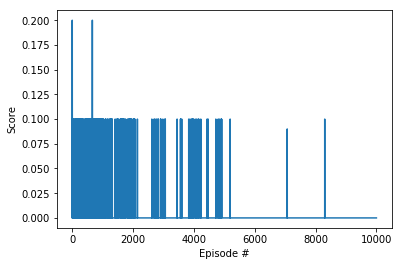

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_list)+1), scores_list)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

def ddpg(n_episodes=1000, max_t=100, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()